 Hoek° Zijde  Runs  Gem.flux     σ
     0     E     2   111.405 1.570
     0     W     2   111.405 1.570
    20     E     2    83.464 1.696
    20     W     2   103.564 0.628
    40     E     2    57.458 0.544
    40     W     2    64.982 1.319
    60     E     2    37.738 0.349
    60     W     2    40.210 0.685


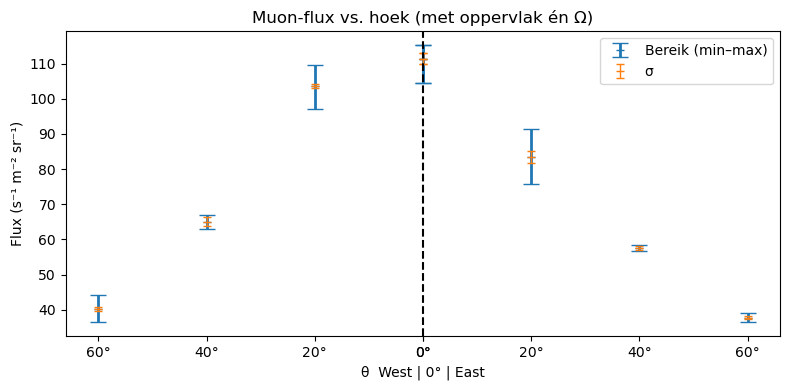

In [57]:
# %% flux per hoek met hoek-afhankelijk oppervlak én solid angle
import math, random, pathlib, pandas as pd, numpy as np, matplotlib.pyplot as plt


# lijst csv-bestanden
bestanden = [
    "hoek_0_c1.csv","hoek_0_c2.csv",
    "hoek_20_E_c1.csv","hoek_20_E_c2.csv","hoek_20_W_c1.csv","hoek_20_W_c2.csv",
    "hoek_40_E_c1.csv","hoek_40_E_c2.csv","hoek_40_W_c1.csv","hoek_40_W_c2.csv",
    "hoek_60_E_c1.csv","hoek_60_E_c2.csv","hoek_60_W_c1.csv","hoek_60_W_c2.csv",
]

d_breedte = 0.1
d_lengte = 0.65
afstand = 0.8

def oppervlak(theta_graden):
    θ = math.radians(theta_graden)
    return 0.094 * 0.325 * math.cos(θ) + 0.094 * 0.05 * math.cos(θ)

def solid_angle(theta_graden):
    return oppervlak(theta_graden) / afstand**2

stats = {}
for naam in bestanden:
    if not pathlib.Path(naam).exists():
        continue
    parts = naam.split('_')
    hoek  = int(parts[1])
    zijde = 'E' if 'E' in parts else 'W' if 'W' in parts else 'E'

    header = pd.read_csv(naam, nrows=1)
    N = int(header["Total coincidences"][0])
    t = float(header["Total runtime (s)"][0])

    area = oppervlak(hoek)
    omega = solid_angle(hoek)
    flux_run = N / (t * area * omega)

    key = (hoek, zijde)
    stats.setdefault(key, {'N':0,'t':0.0,'runs':[]})
    stats[key]['N'] += N
    stats[key]['t'] += t
    stats[key]['runs'].append(flux_run)

if (0,'E') in stats and (0,'W') not in stats:
    stats[(0,'W')] = stats[(0,'E')]

rijen, x, y, lo, hi = [], [], [], [], []
for (hoek, zijde), d in sorted(stats.items()):
    area  = oppervlak(hoek)
    omega = solid_angle(hoek)
    mean  = d['N'] / (d['t'] * area * omega)
    sigma = math.sqrt(d['N']) / (d['t'] * area * omega)
    rijen.append([hoek, zijde, len(d['runs']), round(mean,3), round(sigma,3)])
    pos   = hoek if zijde=='E' else -hoek
    x.append(pos); y.append(mean)
    lo.append(mean - min(d['runs'])); hi.append(max(d['runs']) - mean)

tabel = pd.DataFrame(rijen, columns=["Hoek°","Zijde","Runs","Gem.flux","σ"])
print(tabel.to_string(index=False))
lo = np.maximum(lo,0); hi = np.maximum(hi,0); ysig = np.maximum(ysig,0)


plt.figure(figsize=(8,4))
plt.errorbar(x, y, yerr=[lo,hi], fmt="_", elinewidth=2, capsize=6,
             label="Bereik (min–max)")
plt.errorbar(x, y, yerr=[r[4] for r in rijen], fmt="_", elinewidth=1,
             capsize=3, label="σ")
plt.axvline(0,color='k',ls='--')
plt.xticks(x,[f"{abs(v):.0f}°" for v in x])
plt.xlabel("θ  West | 0° | East")
plt.ylabel("Flux (s⁻¹ m⁻² sr⁻¹)")
plt.title("Muon-flux vs. hoek (met oppervlak én Ω)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


 Hoek° Zijde  Runs  Gem.flux     σ
     0     E     2    72.698 1.025
     0     W     2    69.261 0.976
    20     E     2    49.343 1.003
    20     W     2    59.242 0.359
    40     E     2    28.095 0.266
    40     W     2    28.335 0.575
    60     E     2    11.513 0.106
    60     W     2    12.155 0.207


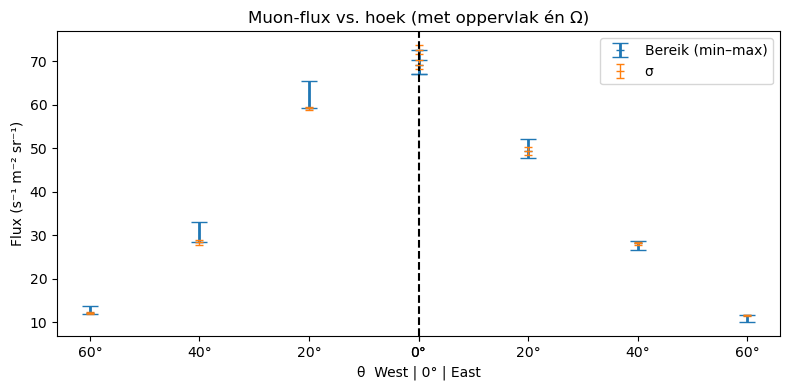

In [56]:
# %% flux per hoek met hoek-afhankelijk oppervlak én solid angle
import math, random, pathlib, pandas as pd, numpy as np, matplotlib.pyplot as plt


# lijst csv-bestanden
bestanden = [
    "hoek_0_c1.csv","hoek_0_c2.csv",
    "hoek_20_E_c1.csv","hoek_20_E_c2.csv","hoek_20_W_c1.csv","hoek_20_W_c2.csv",
    "hoek_40_E_c1.csv","hoek_40_E_c2.csv","hoek_40_W_c1.csv","hoek_40_W_c2.csv",
    "hoek_60_E_c1.csv","hoek_60_E_c2.csv","hoek_60_W_c1.csv","hoek_60_W_c2.csv",
]

d_breedte = 0.1
d_lengte = 0.65
afstand = 0.8

def oppervlak(theta_graden):
    θ = math.radians(theta_graden)
    return 0.094 * 0.325 * math.cos(θ) + 0.094 * 0.05 * math.cos(θ)

def solid_angle(theta_deg, shots=30_000):
    th = math.radians(theta_deg)
    good = 0
    for _ in range(shots):
        x0 = (random.random()-0.5)*d_breedte
        y0 = (random.random()-0.5)*d_lengte

        u, v = random.random(), random.random()
        cosz = u                       # 0..1
        sinz = math.sqrt(1-cosz*cosz)
        phi  = 2*math.pi*v
        dx, dy, dz = sinz*math.cos(phi), sinz*math.sin(phi), -cosz

        dy_ =  dy*math.cos(th) - dz*math.sin(th)
        dz_ =  dy*math.sin(th) + dz*math.cos(th)

        s    = -afstand / dz_
        xhit = x0 + s*dx
        yhit = y0 + s*dy_

        if abs(xhit) <= d_breedte/2 and abs(yhit) <= d_lengte/2:
            good += 1
    return 2*math.pi*good/shots

stats = {}
for naam in bestanden:
    if not pathlib.Path(naam).exists():
        continue
    parts = naam.split('_')
    hoek  = int(parts[1])
    zijde = 'E' if 'E' in parts else 'W' if 'W' in parts else 'E'

    header = pd.read_csv(naam, nrows=1)
    N = int(header["Total coincidences"][0])
    t = float(header["Total runtime (s)"][0])

    area = oppervlak(hoek)
    omega = solid_angle(hoek)
    flux_run = N / (t * area * omega)

    key = (hoek, zijde)
    stats.setdefault(key, {'N':0,'t':0.0,'runs':[]})
    stats[key]['N'] += N
    stats[key]['t'] += t
    stats[key]['runs'].append(flux_run)

if (0,'E') in stats and (0,'W') not in stats:
    stats[(0,'W')] = stats[(0,'E')]

rijen, x, y, lo, hi = [], [], [], [], []
for (hoek, zijde), d in sorted(stats.items()):
    area  = oppervlak(hoek)
    omega = solid_angle(hoek)
    mean  = d['N'] / (d['t'] * area * omega)
    sigma = math.sqrt(d['N']) / (d['t'] * area * omega)
    rijen.append([hoek, zijde, len(d['runs']), round(mean,3), round(sigma,3)])
    pos   = hoek if zijde=='E' else -hoek
    x.append(pos); y.append(mean)
    lo.append(mean - min(d['runs'])); hi.append(max(d['runs']) - mean)

tabel = pd.DataFrame(rijen, columns=["Hoek°","Zijde","Runs","Gem.flux","σ"])
print(tabel.to_string(index=False))
lo = np.maximum(lo,0); hi = np.maximum(hi,0); ysig = np.maximum(ysig,0)


plt.figure(figsize=(8,4))
plt.errorbar(x, y, yerr=[lo,hi], fmt="_", elinewidth=2, capsize=6,
             label="Bereik (min–max)")
plt.errorbar(x, y, yerr=[r[4] for r in rijen], fmt="_", elinewidth=1,
             capsize=3, label="σ")
plt.axvline(0,color='k',ls='--')
plt.xticks(x,[f"{abs(v):.0f}°" for v in x])
plt.xlabel("θ  West | 0° | East")
plt.ylabel("Flux (s⁻¹ m⁻² sr⁻¹)")
plt.title("Muon-flux vs. hoek (met oppervlak én Ω)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


Projectie Wet: $$A_\text{proj} = A\cos\theta$$

$$Φ(\theta)=I_0 \cos\theta$$